## 1. Setup & Configuration

In [2]:
# Standard library imports
import sys
import warnings
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Import project modules
from src.config import data_config, model_config
from src.logger import setup_logger
from src.data_loader import DataLoader
from src.feature_engineer import CreditCardFeatureEngineer
from src.preprocessor import DataPreprocessor
from src.model_trainer import ModelTrainer
from src.model_evaluator import ModelEvaluator

# Initialize logger
logger = setup_logger('creditcard_fraud_pipeline', 'creditcard_fraud_pipeline.log')
logger.info("="*80)
logger.info("CREDIT CARD FRAUD DETECTION PIPELINE INITIALIZED")
logger.info("="*80)

print("✓ All modules imported successfully")
print(f"✓ Project root: {project_root}")
print(f"✓ Data directory: {data_config.creditcard_data_path.parent}")

2026-01-31 08:37:22,179 - creditcard_fraud_pipeline - INFO - ================================================================================
2026-01-31 08:37:22,180 - creditcard_fraud_pipeline - INFO - CREDIT CARD FRAUD DETECTION PIPELINE INITIALIZED
2026-01-31 08:37:22,180 - creditcard_fraud_pipeline - INFO - ================================================================================
✓ All modules imported successfully
✓ Project root: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions
✓ Data directory: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/raw
2026-01-31 08:37:22,180 - creditcard_fraud_pipeline - INFO - CREDIT CARD FRAUD DETECTION PIPELINE INITIALIZED
2026-01-31 08:37:22,180 - creditcard_fraud_pipeline - INFO - ================================================================================
✓ All modules imported successfully
✓ Project root: /home/abel/Desktop/Copi

## 2. Data Ingestion

In [3]:
# Initialize DataLoader
data_loader = DataLoader(config=data_config)

print("\n" + "="*80)
print("LOADING CREDIT CARD FRAUD DATA")
print("="*80)

# Load credit card data
creditcard_data = data_loader.load_creditcard_data()
print(f"\n✓ Loaded {len(creditcard_data):,} credit card transactions")
print(f"  - Fraud cases: {creditcard_data['Class'].sum():,} ({creditcard_data['Class'].mean()*100:.4f}%)")
print(f"  - Normal cases: {(creditcard_data['Class']==0).sum():,} ({(creditcard_data['Class']==0).mean()*100:.4f}%)")
print(f"  - Features: {creditcard_data.shape[1]}")
print(f"  - PCA Features (V1-V28): 28 anonymized features")
print(f"  - Time: Transaction time in seconds")
print(f"  - Amount: Transaction amount")

print("\n" + "="*80)
print("✓ DATA LOADING COMPLETE")
print("="*80)


LOADING CREDIT CARD FRAUD DATA
2026-01-31 08:37:24,389 - src.data_loader - INFO - Loading credit card data from /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/data/raw/creditcard.csv
2026-01-31 08:37:25,630 - src.data_loader - INFO - Successfully loaded 284807 credit card records
2026-01-31 08:37:25,631 - src.data_loader - WARNING - Target column 'class' not found in creditcard data
2026-01-31 08:37:25,630 - src.data_loader - INFO - Successfully loaded 284807 credit card records
2026-01-31 08:37:25,631 - src.data_loader - WARNING - Target column 'class' not found in creditcard data

✓ Loaded 284,807 credit card transactions
  - Fraud cases: 492 (0.1727%)
  - Normal cases: 284,315 (99.8273%)
  - Features: 31
  - PCA Features (V1-V28): 28 anonymized features
  - Time: Transaction time in seconds
  - Amount: Transaction amount

✓ DATA LOADING COMPLETE

✓ Loaded 284,807 credit card transactions
  - Fraud cases: 492 (0.1727%)
  - Normal 

### Data Overview Visualizations

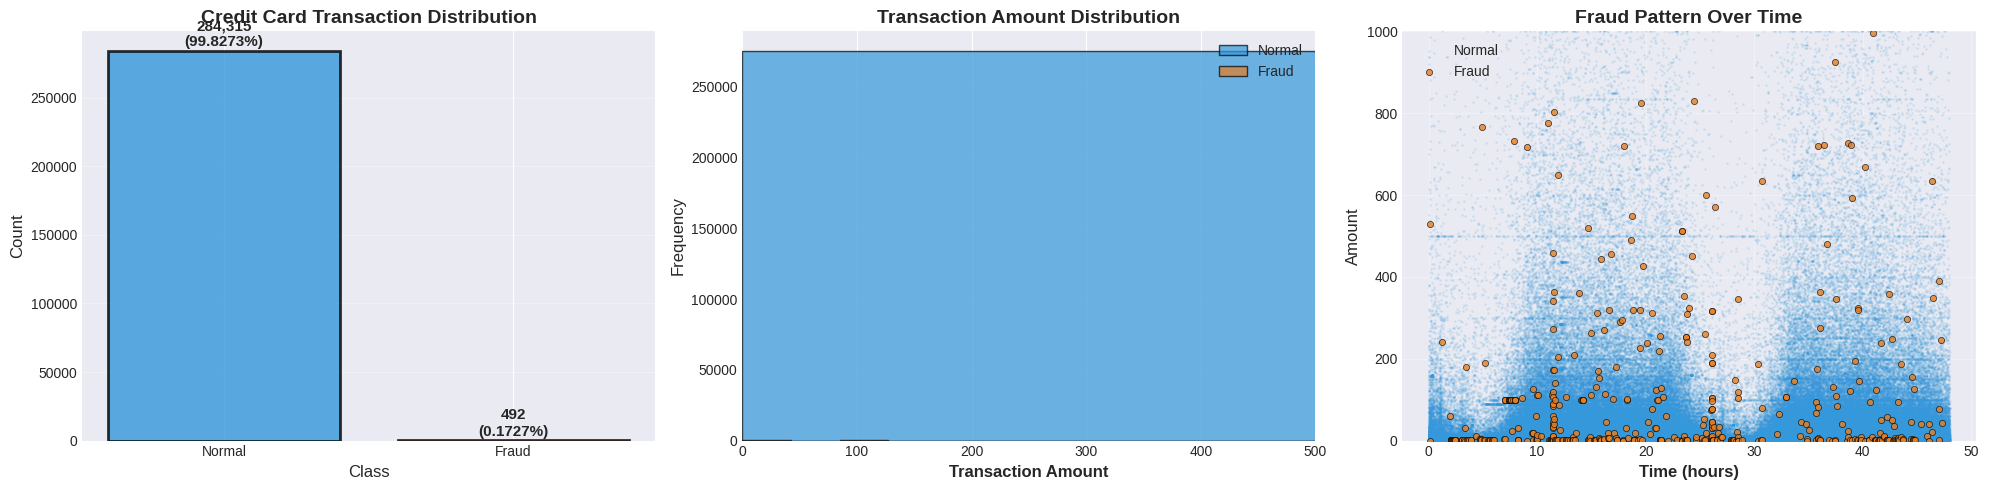


EXTREME CLASS IMBALANCE: 578:1 ratio
   → Will handle with SMOTE during preprocessing


In [4]:
# Visualize class imbalance and transaction patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Class distribution
cc_counts = creditcard_data['Class'].value_counts()
axes[0].bar(['Normal', 'Fraud'], cc_counts.values, color=['#3498db', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_title('Credit Card Transaction Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
for i, v in enumerate(cc_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}\n({v/len(creditcard_data)*100:.4f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Amount distribution by class
axes[1].hist(creditcard_data[creditcard_data['Class']==0]['Amount'], bins=50, alpha=0.7, 
             label='Normal', color='#3498db', edgecolor='black')
axes[1].hist(creditcard_data[creditcard_data['Class']==1]['Amount'], bins=50, alpha=0.7, 
             label='Fraud', color='#e67e22', edgecolor='black')
axes[1].set_xlabel('Transaction Amount', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlim([0, 500])  # Focus on typical range

# Time distribution
time_hours = creditcard_data['Time'] / 3600  # Convert to hours
axes[2].scatter(time_hours[creditcard_data['Class']==0], 
                creditcard_data[creditcard_data['Class']==0]['Amount'], 
                alpha=0.1, s=1, label='Normal', color='#3498db')
axes[2].scatter(time_hours[creditcard_data['Class']==1], 
                creditcard_data[creditcard_data['Class']==1]['Amount'], 
                alpha=0.8, s=20, label='Fraud', color='#e67e22', edgecolor='black', linewidth=0.5)
axes[2].set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Amount', fontsize=12)
axes[2].set_title('Fraud Pattern Over Time', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0, 1000])

plt.tight_layout()
plt.show()

imbalance_ratio = cc_counts[0]/cc_counts[1]
print(f"\nEXTREME CLASS IMBALANCE: {imbalance_ratio:.0f}:1 ratio")
print(f"   → Will handle with SMOTE during preprocessing")

## 3. Feature Engineering

In [5]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Initialize feature engineer
feature_engineer = CreditCardFeatureEngineer()

# Engineer features
creditcard_data_engineered = feature_engineer.engineer_features(creditcard_data, fit=True)

print(f"\n✓ Feature engineering completed")
print(f"  - Original features: {creditcard_data.shape[1]}")
print(f"  - Engineered features: {creditcard_data_engineered.shape[1]}")
print(f"  - New features added: {creditcard_data_engineered.shape[1] - creditcard_data.shape[1]}")

# Display new features
new_features = [col for col in creditcard_data_engineered.columns if col not in creditcard_data.columns]
if new_features:
    print(f"\nNew features created:")
    for i, feat in enumerate(new_features, 1):
        print(f"  {i:2d}. {feat}")

print("\n" + "="*80)
print("✓ FEATURE ENGINEERING COMPLETE")
print("="*80)


FEATURE ENGINEERING
2026-01-31 08:37:40,257 - src.feature_engineer - INFO - Engineering features for credit card data
2026-01-31 08:37:40,265 - src.feature_engineer - INFO - Created and scaled time features
2026-01-31 08:37:40,265 - src.feature_engineer - INFO - Created and scaled time features
2026-01-31 08:37:40,275 - src.feature_engineer - INFO - Created and scaled amount features
2026-01-31 08:37:40,280 - src.feature_engineer - INFO - Created interaction features

✓ Feature engineering completed
  - Original features: 31
  - Engineered features: 42
  - New features added: 11

New features created:
   1. scaled_time
   2. hour
   3. day
   4. scaled_amount
   5. log_amount
   6. amount_category
   7. V1_amount_interaction
   8. V2_amount_interaction
   9. V3_amount_interaction
  10. V4_amount_interaction
  11. V5_amount_interaction

✓ FEATURE ENGINEERING COMPLETE
2026-01-31 08:37:40,275 - src.feature_engineer - INFO - Created and scaled amount features
2026-01-31 08:37:40,280 - src

### Feature Correlation Analysis

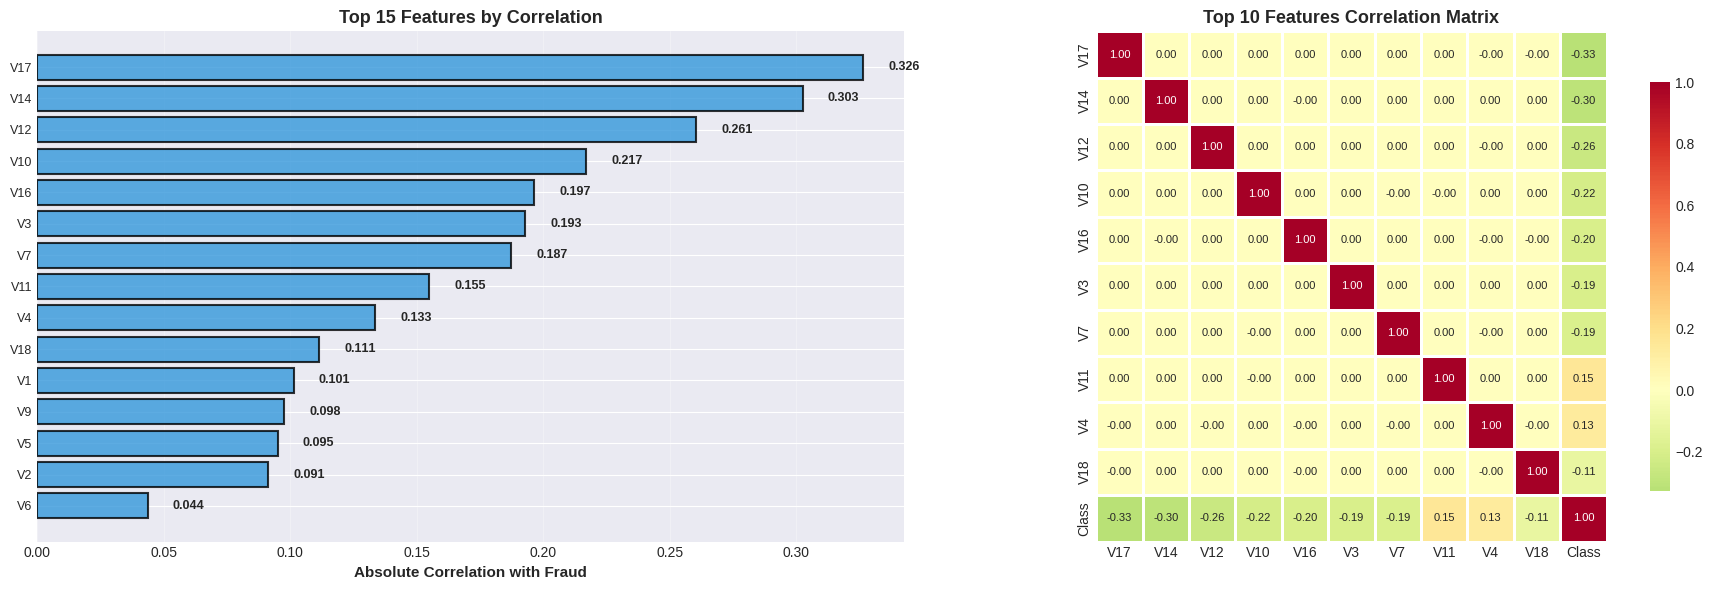


✓ Feature correlation analysis complete

Note: V1-V28 are PCA-transformed features (anonymized for privacy)


In [6]:
# Visualize feature correlations with target
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 features by correlation
cc_numeric = creditcard_data_engineered.select_dtypes(include=[np.number])
target_col = 'Class' if 'Class' in cc_numeric.columns else 'class'
cc_corr = cc_numeric.corr()[target_col].abs().sort_values(ascending=False)[1:16]

axes[0].barh(range(len(cc_corr)), cc_corr.values, color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(cc_corr)))
axes[0].set_yticklabels(cc_corr.index, fontsize=9)
axes[0].set_xlabel('Absolute Correlation with Fraud', fontsize=11, fontweight='bold')
axes[0].set_title('Top 15 Features by Correlation', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

for i, v in enumerate(cc_corr.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=9)

# Correlation heatmap of top features
top_features = cc_corr.index[:10].tolist() + [target_col]
corr_matrix = cc_numeric[top_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1],
            annot_kws={'size': 8})
axes[1].set_title('Top 10 Features Correlation Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Feature correlation analysis complete")
print("\nNote: V1-V28 are PCA-transformed features (anonymized for privacy)")

## 4. Train/Test Split & Preprocessing

In [7]:
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("PREPARING TRAIN/TEST SPLIT")
print("="*80)

# Split data
target_col = 'Class' if 'Class' in creditcard_data_engineered.columns else 'class'
X = creditcard_data_engineered.drop(columns=[target_col])
y = creditcard_data_engineered[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=data_config.test_size,
    random_state=data_config.random_state,
    stratify=y
)

print(f"\nTraining set: {len(X_train):,} samples")
print(f"  - Fraud: {y_train.sum():,} ({y_train.mean()*100:.4f}%)")
print(f"  - Normal: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.4f}%)")
print(f"\nTest set: {len(X_test):,} samples")
print(f"  - Fraud: {y_test.sum():,} ({y_test.mean()*100:.4f}%)")
print(f"  - Normal: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.4f}%)")

print("\n" + "="*80)
print("✓ DATA SPLIT COMPLETE")
print("="*80)


PREPARING TRAIN/TEST SPLIT

Training set: 227,845 samples
  - Fraud: 394 (0.1729%)
  - Normal: 227,451 (99.8271%)

Test set: 56,962 samples
  - Fraud: 98 (0.1720%)
  - Normal: 56,864 (99.8280%)

✓ DATA SPLIT COMPLETE


In [8]:
print("\n" + "="*80)
print("PREPROCESSING: SCALING & SMOTE")
print("="*80)

# Initialize preprocessor with SMOTE
preprocessor = DataPreprocessor(use_smote=True)

print(f"\nBefore SMOTE: {len(X_train):,} samples")
print(f"  Class distribution: {(y_train==0).sum():,} Normal | {y_train.sum():,} Fraud")
print(f"  Imbalance ratio: {(y_train==0).sum() / y_train.sum():.0f}:1")

# Fit and transform training data
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nAfter SMOTE: {len(X_train_processed):,} samples")
print(f"  Class distribution: {(y_train_processed==0).sum():,} Normal | {y_train_processed.sum():,} Fraud")
print(f"  - Fraud: {y_train_processed.sum():,} ({y_train_processed.mean()*100:.2f}%)")
print(f"  - Normal: {(y_train_processed==0).sum():,} ({(y_train_processed==0).mean()*100:.2f}%)")
print(f"\n✓ Class balance achieved!")
print(f"✓ Training samples increased by {len(X_train_processed) - len(X_train):,} ({(len(X_train_processed)/len(X_train) - 1)*100:.1f}%)")

print("\n" + "="*80)
print("✓ PREPROCESSING COMPLETE")
print("="*80)


PREPROCESSING: SCALING & SMOTE

Before SMOTE: 227,845 samples
  Class distribution: 227,451 Normal | 394 Fraud
  Imbalance ratio: 577:1
2026-01-31 08:37:57,835 - src.preprocessor - INFO - Fitting and transforming training data
2026-01-31 08:37:58,020 - src.preprocessor - INFO - Fitted and scaled features
2026-01-31 08:37:58,022 - src.preprocessor - INFO - Original class distribution: {0: 227451, 1: 394}
2026-01-31 08:37:58,020 - src.preprocessor - INFO - Fitted and scaled features
2026-01-31 08:37:58,022 - src.preprocessor - INFO - Original class distribution: {0: 227451, 1: 394}
2026-01-31 08:37:58,264 - src.preprocessor - INFO - Resampled class distribution: {0: 227451, 1: 113725}
2026-01-31 08:37:58,266 - src.preprocessor - INFO - Transforming data
2026-01-31 08:37:58,264 - src.preprocessor - INFO - Resampled class distribution: {0: 227451, 1: 113725}
2026-01-31 08:37:58,266 - src.preprocessor - INFO - Transforming data
2026-01-31 08:37:58,297 - src.preprocessor - INFO - Scaled fea

## 5. Model Training

Train three models: Logistic Regression, Random Forest, and XGBoost.

In [9]:
print("\n" + "="*80)
print("TRAINING FRAUD DETECTION MODELS")
print("="*80)

# Define models to train
model_types = ['logistic_regression', 'random_forest', 'xgboost']
models = {}

for model_type in model_types:
    print(f"\n{'-'*80}")
    print(f"Training: {model_type.replace('_', ' ').title()}")
    print(f"{'-'*80}")
    
    # Initialize and train model
    trainer = ModelTrainer(model_type=model_type)
    trainer.train(X_train_processed, y_train_processed)
    
    # Store trained model
    models[model_type] = trainer
    
    print(f"\n✓ {model_type.replace('_', ' ').title()} training complete")

print("\n" + "="*80)
print(f"✓ ALL MODELS TRAINED ({len(models)} models)")
print("="*80)


TRAINING FRAUD DETECTION MODELS

--------------------------------------------------------------------------------
Training: Logistic Regression
--------------------------------------------------------------------------------
2026-01-31 08:38:00,474 - src.model_trainer - INFO - Initialized Logistic Regression model
2026-01-31 08:38:00,474 - src.model_trainer - INFO - Training logistic_regression model on 341176 samples
2026-01-31 08:38:00,474 - src.model_trainer - INFO - Training logistic_regression model on 341176 samples
2026-01-31 08:38:03,863 - src.model_trainer - INFO - Model training complete
2026-01-31 08:38:03,863 - src.model_trainer - INFO - Model training complete
2026-01-31 08:38:03,940 - src.model_trainer - INFO - Training accuracy: 0.9629
2026-01-31 08:38:03,944 - src.model_trainer - INFO - Performing 5-fold cross-validation
2026-01-31 08:38:03,940 - src.model_trainer - INFO - Training accuracy: 0.9629
2026-01-31 08:38:03,944 - src.model_trainer - INFO - Performing 5-fold 

## 6. Model Evaluation

Comprehensive evaluation with all metrics including AUC-PR (critical for extreme imbalance).

In [10]:
print("\n" + "="*80)
print("EVALUATING MODELS")
print("="*80)

# Initialize evaluator
evaluator = ModelEvaluator(threshold=0.5)

results = {}

for model_name, trainer in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name.replace('_', ' ').title()}")
    print(f"{'='*80}")
    
    # Get predictions
    y_pred_proba = trainer.predict_proba(X_test_processed)
    y_pred = trainer.predict(X_test_processed)
    
    # Evaluate
    metrics = evaluator.evaluate(y_test, y_pred_proba, y_pred)
    results[model_name] = metrics
    
    # Display metrics
    print(f"\n{'Performance Metrics':^80}")
    print(f"{'-'*80}")
    print(f"  Accuracy:           {metrics['accuracy']:.4f}")
    print(f"  Precision:          {metrics['precision']:.4f}")
    print(f"  Recall:             {metrics['recall']:.4f}")
    print(f"  F1-Score:           {metrics['f1_score']:.4f}")
    print(f"  ROC-AUC:            {metrics['roc_auc']:.4f}")
    print(f"  AUC-PR:             {metrics['average_precision']:.4f} ⭐")
    print(f"  Specificity:        {metrics['specificity']:.4f}")
    print(f"{'-'*80}")

print("\n" + "="*80)
print("✓ MODEL EVALUATION COMPLETE")
print("="*80)


EVALUATING MODELS

Model: Logistic Regression
2026-01-31 08:41:41,029 - src.model_evaluator - INFO - Evaluating model performance
2026-01-31 08:41:41,177 - src.model_evaluator - INFO - 
2026-01-31 08:41:41,178 - src.model_evaluator - INFO - EVALUATION METRICS
2026-01-31 08:41:41,179 - src.model_evaluator - INFO - ============================================================
2026-01-31 08:41:41,179 - src.model_evaluator - INFO - Accuracy:           0.9724
2026-01-31 08:41:41,179 - src.model_evaluator - INFO - Precision:          0.0544
2026-01-31 08:41:41,179 - src.model_evaluator - INFO - Recall:             0.9184
2026-01-31 08:41:41,180 - src.model_evaluator - INFO - F1 Score:           0.1027
2026-01-31 08:41:41,180 - src.model_evaluator - INFO - ROC AUC:            0.9748
2026-01-31 08:41:41,180 - src.model_evaluator - INFO - Average Precision:  0.7298
2026-01-31 08:41:41,181 - src.model_evaluator - INFO - Specificity:        0.9725
2026-01-31 08:41:41,181 - src.model_evaluator - I

### Model Comparison Table

In [11]:
# Create comparison DataFrame
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Model': [k.replace('_', ' ').title() for k in results.keys()],
    'Accuracy': [v['accuracy'] for v in results.values()],
    'Precision': [v['precision'] for v in results.values()],
    'Recall': [v['recall'] for v in results.values()],
    'F1-Score': [v['f1_score'] for v in results.values()],
    'ROC-AUC': [v['roc_auc'] for v in results.values()],
    'AUC-PR': [v['average_precision'] for v in results.values()]
})

print("\n" + comparison.to_string(index=False))

# Identify best model
best_model = comparison.loc[comparison['F1-Score'].idxmax(), 'Model']
best_f1 = comparison['F1-Score'].max()
best_recall = comparison.loc[comparison['F1-Score'].idxmax(), 'Recall']
best_auc_pr = comparison.loc[comparison['F1-Score'].idxmax(), 'AUC-PR']

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model}")
print(f"{'='*80}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Recall:   {best_recall:.4f} (catches {best_recall*100:.1f}% of fraud)")
print(f"   AUC-PR:   {best_auc_pr:.4f}")
print(f"{'='*80}")


MODEL PERFORMANCE COMPARISON

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   AUC-PR
Logistic Regression  0.972385   0.054381 0.918367  0.102681 0.974768 0.729843
      Random Forest  0.998209   0.488636 0.877551  0.627737 0.984788 0.824416
            Xgboost  0.998648   0.569536 0.877551  0.690763 0.980970 0.864360

🏆 BEST MODEL: Xgboost
   F1-Score: 0.6908
   Recall:   0.8776 (catches 87.8% of fraud)
   AUC-PR:   0.8644


### Threshold Simulation (Recall vs Threshold)
Explore how lowering the classification threshold increases recall at the cost of precision.


THRESHOLD SIMULATION: RECALL VS THRESHOLD

Recall/Precision by Threshold:
 threshold   recall  precision
      0.05 0.959184   0.006260
      0.10 0.948980   0.010091
      0.15 0.948980   0.014253
      0.20 0.938776   0.018699
      0.25 0.918367   0.023071
      0.30 0.918367   0.027864
      0.35 0.918367   0.033408
      0.40 0.918367   0.039964
      0.45 0.918367   0.047443
      0.50 0.918367   0.054381
      0.55 0.918367   0.061392
      0.60 0.918367   0.070644
      0.65 0.908163   0.082714
      0.70 0.908163   0.095905
      0.75 0.897959   0.114583
      0.80 0.887755   0.133846
      0.85 0.887755   0.160813
      0.90 0.887755   0.189542
      0.95 0.887755   0.231383

Recall/Precision by Threshold:
 threshold   recall  precision
      0.05 0.959184   0.006260
      0.10 0.948980   0.010091
      0.15 0.948980   0.014253
      0.20 0.938776   0.018699
      0.25 0.918367   0.023071
      0.30 0.918367   0.027864
      0.35 0.918367   0.033408
      0.40 0.918367   0.0

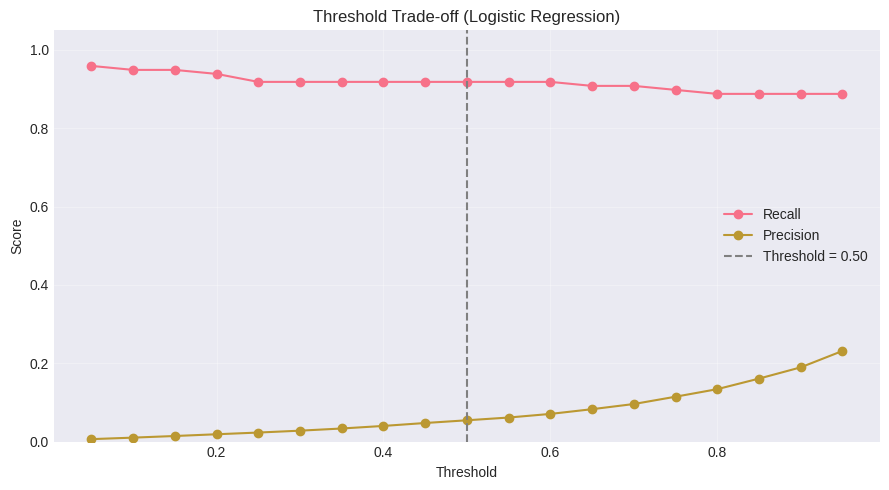


✓ Threshold simulation complete


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score
print("\n" + "="*80)
print("THRESHOLD SIMULATION: RECALL VS THRESHOLD")
print("="*80)

# Pick a model to simulate (use best model if available)
selected_model_key = None
if 'best_model_key' in globals():
    selected_model_key = best_model_key
elif 'results' in globals() and isinstance(results, dict) and len(results) > 0:
    selected_model_key = next(iter(results.keys()))
else:
    selected_model_key = None

if selected_model_key is None:
    print("\n⚠️ No trained model found. Run training and evaluation cells first.")
else:
    trainer = models[selected_model_key]
    y_true = y_test
    # Get predicted probabilities for positive class
    y_proba = trainer.predict_proba(X_test_processed)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        recall_t = recall_score(y_true, y_pred_t)
        precision_t = precision_score(y_true, y_pred_t, zero_division=0)
        rows.append({"threshold": t, "recall": recall_t, "precision": precision_t})

    df_thr = pd.DataFrame(rows)
    print("\nRecall/Precision by Threshold:")
    print(df_thr.to_string(index=False))

    # Plot recall vs threshold
    plt.figure(figsize=(9, 5))
    plt.plot(df_thr["threshold"], df_thr["recall"], marker="o", label="Recall")
    plt.plot(df_thr["threshold"], df_thr["precision"], marker="o", label="Precision")
    plt.axvline(0.5, color="gray", linestyle="--", label="Threshold = 0.50")
    plt.title(f"Threshold Trade-off ({selected_model_key.replace('_', ' ').title()})")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n✓ Threshold simulation complete")

### Performance Visualizations

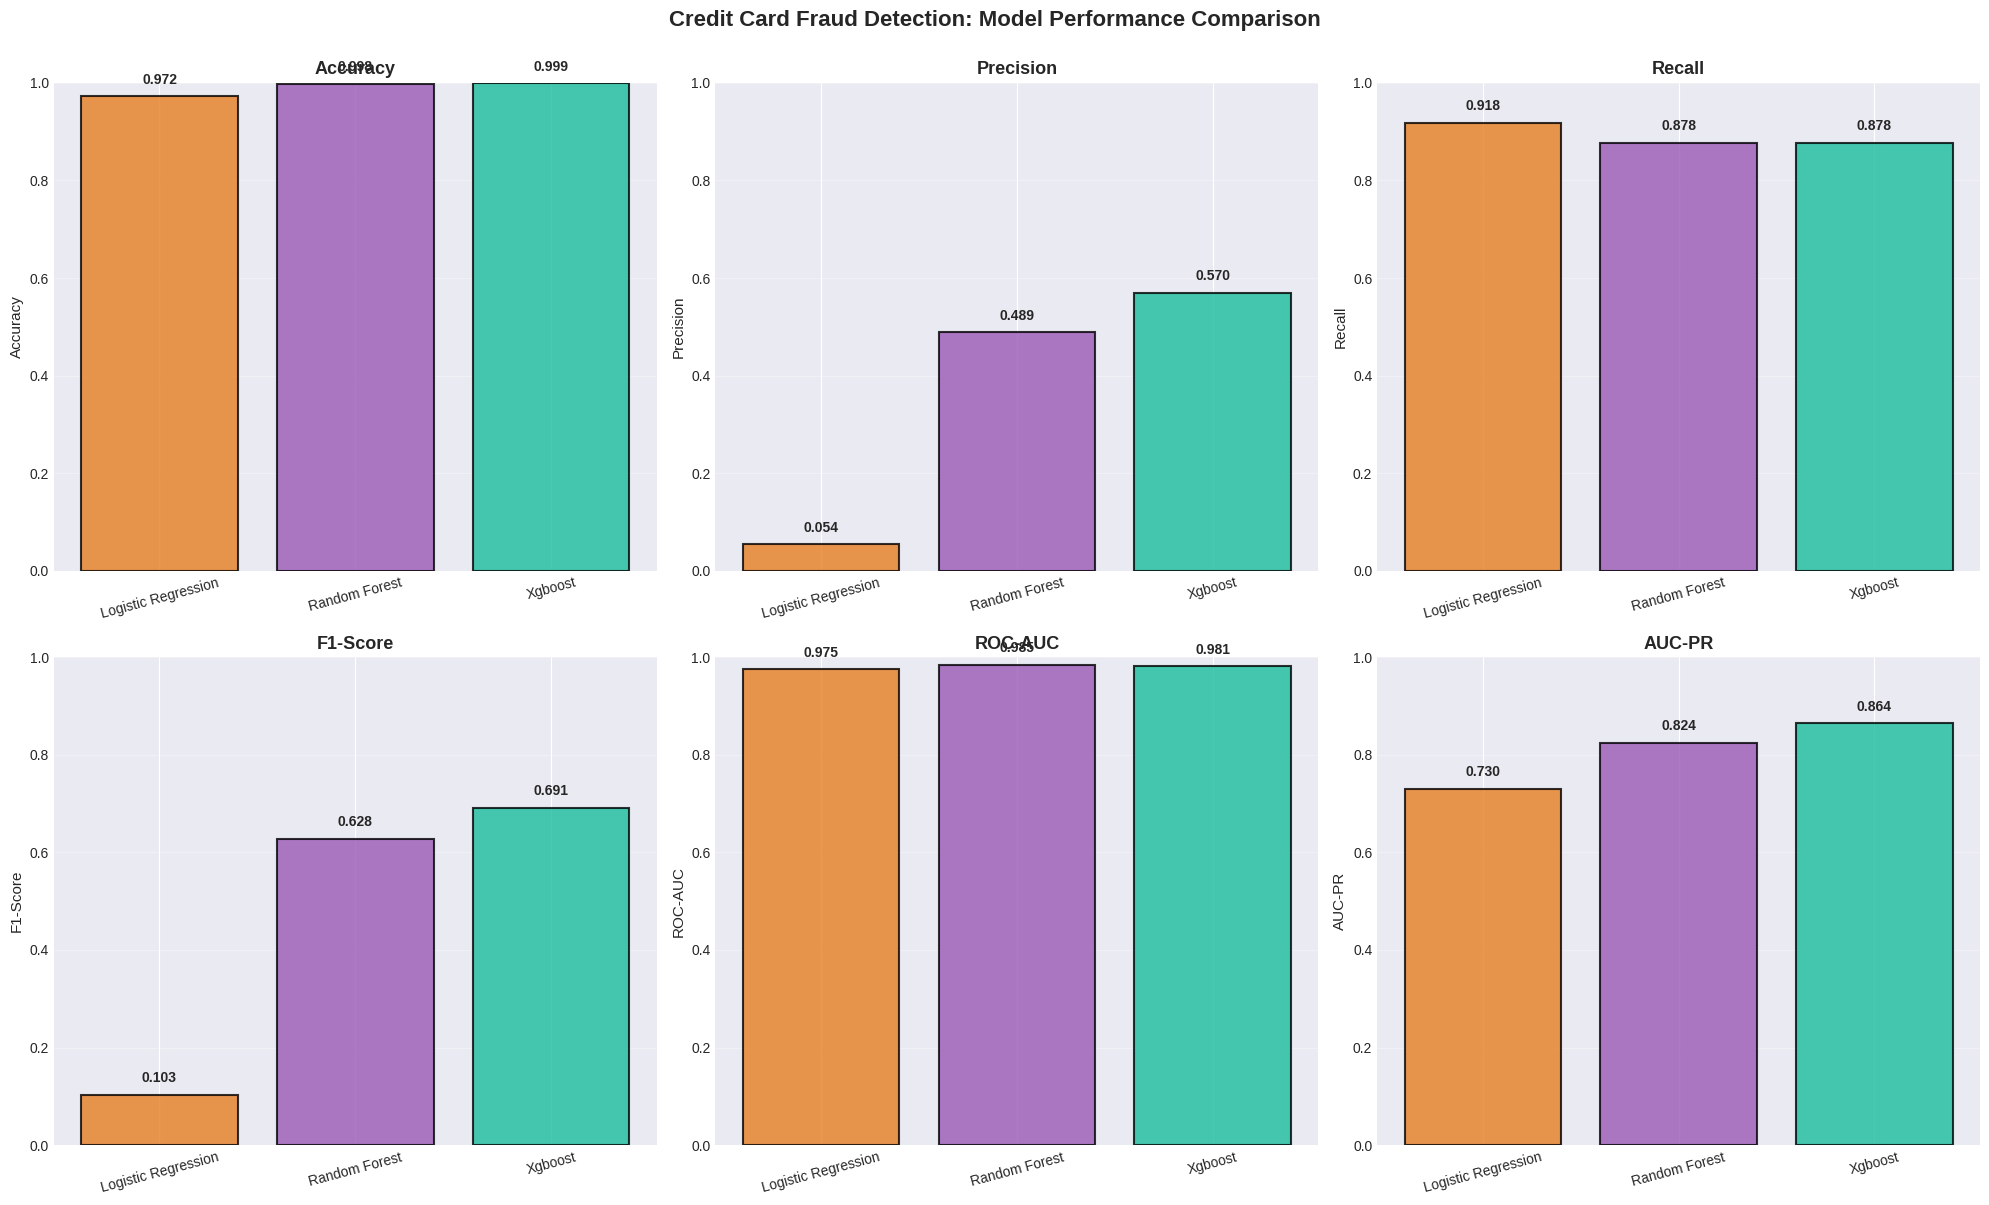

In [13]:
# Performance bar charts
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUC-PR']
colors = ['#e67e22', '#9b59b6', '#1abc9c']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison[metric].values
    bars = ax.bar(comparison['Model'], values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_title(f'{metric}', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=15)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Credit Card Fraud Detection: Model Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Confusion Matrices

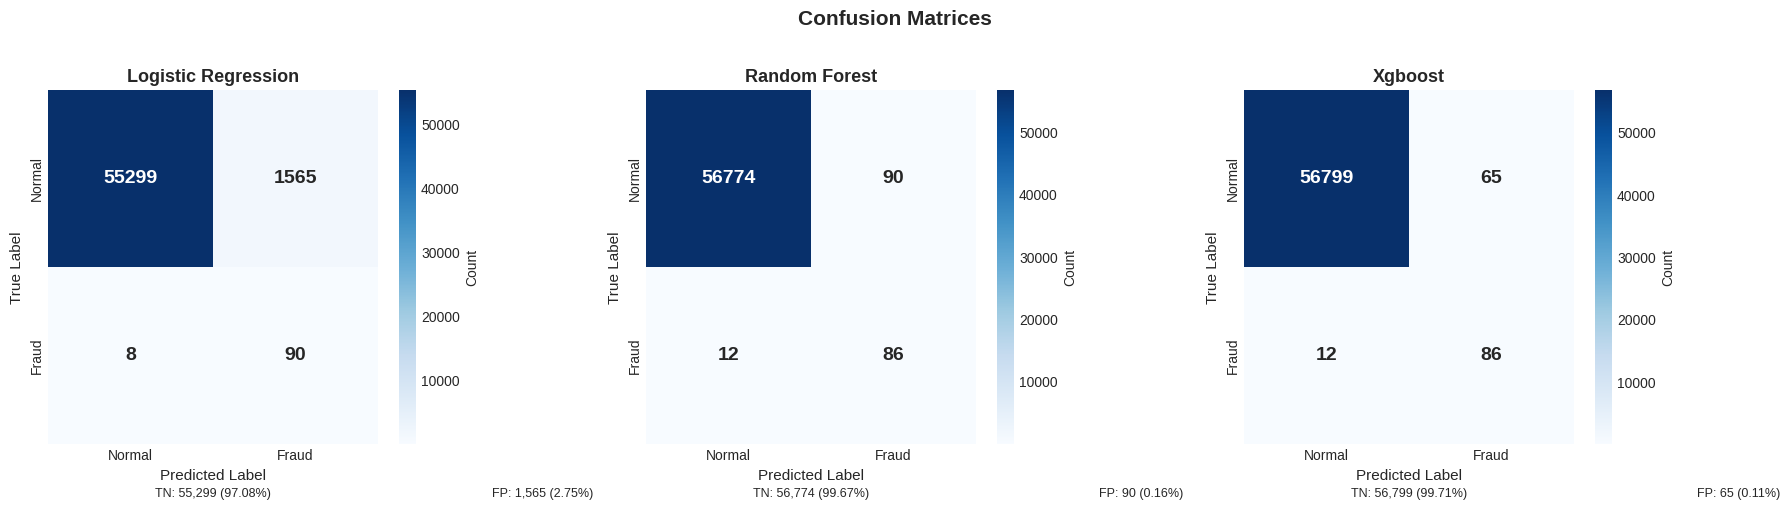

In [14]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, trainer) in enumerate(models.items()):
    y_pred = trainer.predict(X_test_processed)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
    
    axes[idx].set_title(f'{model_name.replace("_", " ").title()}', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    
    # Add percentages
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    axes[idx].text(0.5, -0.15, f'TN: {tn:,} ({tn/total*100:.2f}%)', 
                   ha='center', transform=axes[idx].transAxes, fontsize=9)
    axes[idx].text(1.5, -0.15, f'FP: {fp:,} ({fp/total*100:.2f}%)', 
                   ha='center', transform=axes[idx].transAxes, fontsize=9)

plt.suptitle('Confusion Matrices', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### ROC Curves

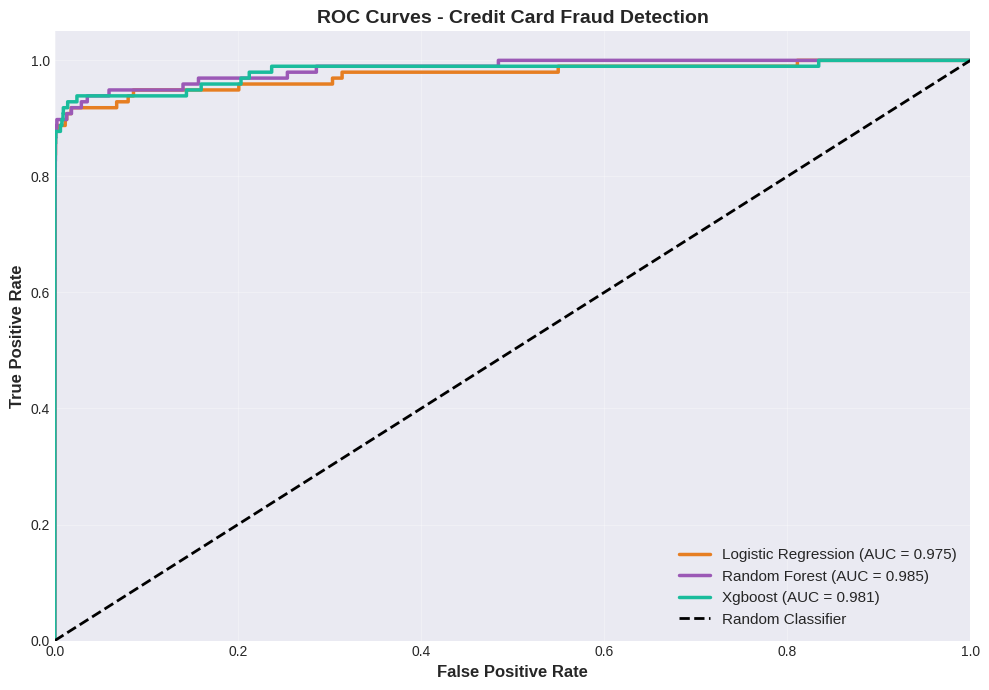

In [15]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
colors = ['#e67e22', '#9b59b6', '#1abc9c']

for idx, (model_name, trainer) in enumerate(models.items()):
    y_pred_proba = trainer.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2.5, 
            label=f'{model_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Credit Card Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curves (Most Important for Extreme Imbalance)

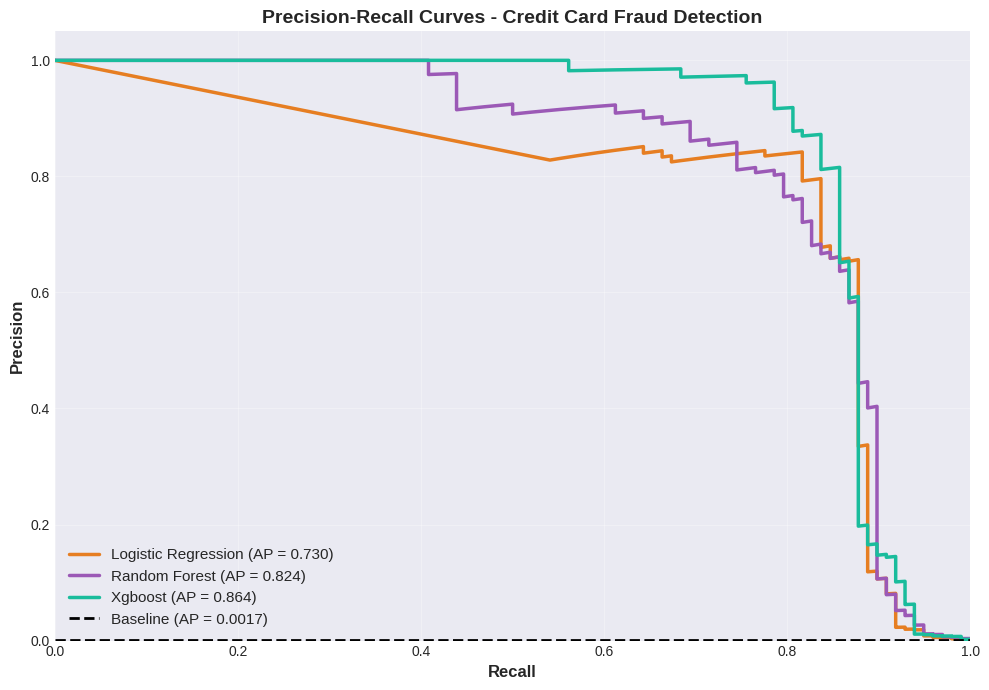


AUC-PR is CRITICAL for extreme class imbalance (577:1 ratio)
   → ROC-AUC can be misleadingly high when classes are highly imbalanced
   → AUC-PR focuses exclusively on fraud class performance


In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))
colors = ['#e67e22', '#9b59b6', '#1abc9c']

for idx, (model_name, trainer) in enumerate(models.items()):
    y_pred_proba = trainer.predict_proba(X_test_processed)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, color=colors[idx], lw=2.5, 
            label=f'{model_name.replace("_", " ").title()} (AP = {avg_precision:.3f})')

# Baseline
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', lw=2, label=f'Baseline (AP = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - Credit Card Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("AUC-PR is CRITICAL for extreme class imbalance ({}:1 ratio)".format(int(imbalance_ratio)))
print("   → ROC-AUC can be misleadingly high when classes are highly imbalanced")
print("   → AUC-PR focuses exclusively on fraud class performance")
print("="*80)

## 7. Feature Importance & Explainability


FEATURE IMPORTANCE ANALYSIS

Xgboost - Top 15 Most Important Features

              Feature  Importance
                  V14    0.337218
                  V10    0.166780
                  V11    0.063160
                  V12    0.042890
                   V4    0.031636
      amount_category    0.027860
                  V17    0.020540
                   V8    0.020226
V1_amount_interaction    0.016203
                  day    0.015741
                  V13    0.014705
                   V3    0.014568
           log_amount    0.014378
                  V18    0.014025
V4_amount_interaction    0.013538


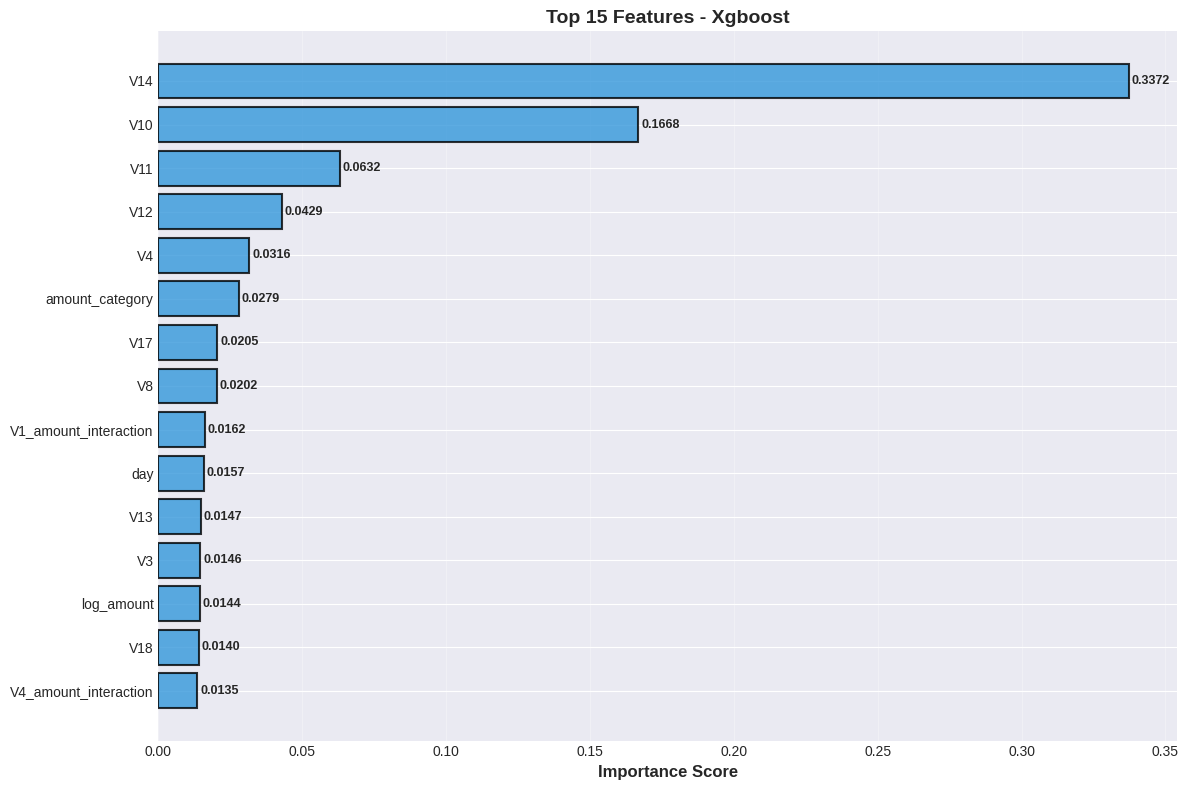


✓ FEATURE IMPORTANCE ANALYSIS COMPLETE


In [17]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get best model
best_model_key = best_model.lower().replace(' ', '_')
best_trainer = models[best_model_key]

if hasattr(best_trainer.model, 'feature_importances_'):
    print(f"\n{'='*80}")
    print(f"{best_model} - Top 15 Most Important Features")
    print(f"{'='*80}")
    
    importance = best_trainer.model.feature_importances_
    feature_names = X_train_processed.columns if hasattr(X_train_processed, 'columns') else [f'Feature_{i}' for i in range(len(importance))]
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(15)
    
    print("\n" + feature_importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], 
             color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Features - {best_model}', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✓ FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("="*80)

### SHAP Analysis

In [19]:
print("\n" + "="*80)
print("SHAP EXPLAINABILITY")
print("="*80)
print("\n📊 For comprehensive SHAP analysis, see: notebooks/shap_explanability.ipynb")
print("\nSHAP Analysis includes:")
print("  1. Summary Plot (Global Feature Importance)")
print("  2. Force Plots (Individual Predictions)")
print("  3. Dependence Plots (Feature Interactions)")
print("  4. Waterfall Charts (Decision Breakdown)")
print("\n" + "="*80)

# Quick SHAP sample (optional)
try:
    import shap
    
    print("\nQuick SHAP Summary:")
    print("-"*80)
    
    explainer = shap.TreeExplainer(best_trainer.model)
    sample_size = min(100, len(X_test_processed))
    shap_values = explainer.shap_values(X_test_processed[:sample_size])
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_processed[:sample_size], 
                      plot_type="bar", show=False, max_display=15)
    plt.title(f'SHAP Feature Importance - {best_model}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✓ SHAP summary generated")
    
except ImportError:
    print("\nSHAP not installed")
except Exception as e:
    print(f"\nSHAP analysis skipped: {str(e)}")


SHAP EXPLAINABILITY

📊 For comprehensive SHAP analysis, see: notebooks/shap_explanability.ipynb

SHAP Analysis includes:
  1. Summary Plot (Global Feature Importance)
  2. Force Plots (Individual Predictions)
  3. Dependence Plots (Feature Interactions)
  4. Waterfall Charts (Decision Breakdown)


SHAP analysis skipped: initialization of _internal failed without raising an exception

SHAP analysis skipped: initialization of _internal failed without raising an exception


## 8. Model Persistence & Production Recommendations

In [21]:
import joblib
from pathlib import Path
from src.config import MODELS_DIR

print("\n" + "="*80)
print("SAVING MODEL TO DISK")
print("="*80)

models_dir = Path(MODELS_DIR)

models_dir.mkdir(parents=True, exist_ok=True)

# Save best model
model_path = models_dir / f"creditcard_{best_model_key}_model.joblib"
best_trainer.save_model(str(model_path))
print(f"\n✓ Model Saved:")
print(f"  Path: {model_path}")
print(f"  Model: {best_model}")
print(f"  F1-Score: {best_f1:.4f}")
print(f"  Recall: {best_recall:.4f}")
print(f"  AUC-PR: {best_auc_pr:.4f}")

# Save preprocessor
preprocessor_path = models_dir / "creditcard_preprocessor.joblib"
joblib.dump(preprocessor, preprocessor_path)
print(f"\n✓ Preprocessor Saved:")
print(f"  Path: {preprocessor_path}")

# Save feature engineer
feature_engineer_path = models_dir / "creditcard_feature_engineer.joblib"
joblib.dump(feature_engineer, feature_engineer_path)
print(f"\n✓ Feature Engineer Saved:")
print(f"  Path: {feature_engineer_path}")

print("\n" + "="*80)
print("✓ ALL ARTIFACTS SAVED")
print("="*80)


SAVING MODEL TO DISK
2026-01-31 08:44:30,132 - src.model_trainer - INFO - Saving model to /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/creditcard_xgboost_model.joblib
2026-01-31 08:44:30,138 - src.model_trainer - INFO - Model saved successfully
2026-01-31 08:44:30,138 - src.model_trainer - INFO - Model saved successfully

✓ Model Saved:
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/creditcard_xgboost_model.joblib
  Model: Xgboost
  F1-Score: 0.6908
  Recall: 0.8776
  AUC-PR: 0.8644

✓ Preprocessor Saved:
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/creditcard_preprocessor.joblib

✓ Feature Engineer Saved:
  Path: /home/abel/Desktop/Copied_with_better_precison/fraud-detection-for-e-commerce-and-bank-transactions/models/creditcard_feature_engineer.joblib

✓ ALL ARTIFACTS SAVED

✓ Model Sav